In [6]:
!git clone https://github.com/AbrahamCamelo/ResearchMethods_GitHub.git

Cloning into 'ResearchMethods_GitHub'...
remote: Enumerating objects: 467, done.
remote: Counting objects: 100% (467/467), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 467 (delta 402), reused 449 (delta 394), pack-reused 0 (from 0)
Receiving objects: 100% (467/467), 2.04 MiB | 9.32 MiB/s, done.
Resolving deltas: 100% (402/402), done.


In [44]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import keras
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [15]:
df_average = pd.read_csv('ResearchMethods_GitHub/ndvi_data/average_ndvi.csv')
df_average['date'] = pd.to_datetime(df_average.date)
df_average = df_average.drop(columns=['Unnamed: 0'])

In [23]:
lst_ndvi = list(df_average.NDVI)

Goal: forecast the next 6 months (12 steps) from the last year (23 steps).

We are going to generate an array of x values that is going to a list of (lists of) predictors which are 23 steps (variables) in the time series and an array of y values that is going to have a list of (lists of) targets having the 12 steps following the 23 steps mentioned before.

In [53]:
n_past = 23
n_future = 1
n_total = n_past + n_future

last_index = len(lst_ndvi) - 1
start_index = last_index - n_total

x_ndvi = []
y_ndvi = []

while start_index > 0:
  x_ndvi.append(lst_ndvi[start_index : start_index + n_past])
  y_ndvi.append(lst_ndvi[start_index + n_past : start_index + + n_total])
  start_index -= 1

x_ndvi = np.array(x_ndvi)
y_ndvi = np.array(y_ndvi)

Data must be in a 3D format (n_samples, n_timesteps, n_features). This reshape is necessary sometimes when using Keras.

It is like having a list of tables.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(x_ndvi, y_ndvi,
                                                    test_size=0.2, random_state=42)
# reshape data into the right format for RNNs
n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_steps = y_train.shape[1]
n_features = 1
X_train_rs = X_train.reshape(n_samples, n_timesteps, n_features )
X_test_rs = X_test.reshape(X_test.shape[0], n_timesteps, n_features )

In [55]:
random.seed(42)
batch_size = 32

simple_model = Sequential([
    LSTM(8, activation='tanh',input_shape=(n_timesteps, n_features)),
    Dense(y_train.shape[1]),
    ])
#simple_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 8)                   │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 329 (1.29 KB)

 Trainable params: 329 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
simple_model.compile(
optimizer=keras.optimizers.Adam(learning_rate=0.01),
loss='mean_absolute_error',
metrics=['mean_absolute_error'],
)
smod_history = simple_model.fit(X_train_rs, y_train,
validation_split=0.2,
epochs=8,
batch_size=batch_size,
shuffle = True
)
preds = simple_model.predict(X_test_rs)

Epoch 1/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 0.5020 - mean_absolute_error: 0.5020 - val_loss: 0.3054 - val_mean_absolute_error: 0.3054
Epoch 2/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2707 - mean_absolute_error: 0.2707 - val_loss: 0.1193 - val_mean_absolute_error: 0.1193
Epoch 3/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1172 - mean_absolute_error: 0.1172 - val_loss: 0.1532 - val_mean_absolute_error: 0.1532
Epoch 4/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1497 - mean_absolute_error: 0.1497 - val_loss: 0.1525 - val_mean_absolute_error: 0.1525
Epoch 5/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1332 - mean_absolute_error: 0.1332 - val_loss: 0.1274 - val_mean_absolute_error: 0.1274
Epoch 6/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1117 - mean_absolute_error: 0.1117 - val_loss: 0.1103 - val_mean_absolute_error: 0.1103
Epoch 7/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0956 - mean_absolute_error: 0.0956 - val_loss: 0.1056 - val_mean_

-17.452647598529552


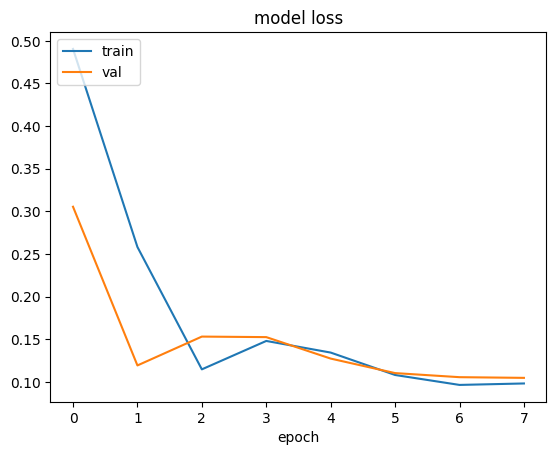

In [57]:
print(r2_score(preds, y_test))
plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

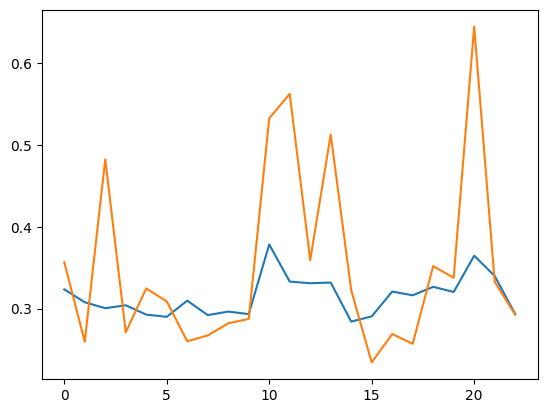

In [59]:
plt.plot(preds)
plt.plot(y_test)
plt.show()

In [50]:
preds

array([[0.31791347, 0.3149133 , 0.3443817 , 0.36195835, 0.26998156,
        0.32763818, 0.32392198, 0.31833124, 0.43262732, 0.34681308,
        0.40857494, 0.25856465],
       [0.3522913 , 0.3399785 , 0.36289185, 0.37601164, 0.28457573,
        0.35209724, 0.33742929, 0.3399564 , 0.4450394 , 0.35906368,
        0.41941178, 0.27855563],
       [0.35206664, 0.34758988, 0.36586404, 0.3801828 , 0.28331152,
        0.3548606 , 0.33539176, 0.34589323, 0.4453122 , 0.3578353 ,
        0.41673505, 0.28224352],
       [0.31368724, 0.3205754 , 0.34443146, 0.36671507, 0.26629278,
        0.32792863, 0.318357  , 0.32109112, 0.43318927, 0.34374   ,
        0.40321067, 0.2588971 ],
       [0.34214276, 0.35609186, 0.36625147, 0.3977849 , 0.27734628,
        0.35322955, 0.32104418, 0.34317905, 0.44794446, 0.34992963,
        0.4037639 , 0.27317318],
       [0.3354545 , 0.33854252, 0.36025017, 0.3718856 , 0.27537426,
        0.34409264, 0.33102977, 0.33953875, 0.43549132, 0.3508147 ,
        0.41144097,